### Import the Lirbraries and load the Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

df = pd.read_csv('mySet.csv')
df.head()

,Name,Magnetic core,Surface,Overall size (nm),Relaxivity (s-1/mmol Fe)( r2),B0 (T),Fe/cell (pg),cell viability
0,Fe2O3-PLL,1,PLL,15.0,NaN,1.5,64.51,0
1,uncoated,1,uncoated,10.0,549.0,4.7,29.30,1
2,D-mannose-coated Fe2O3,1,D-mannose,2.0,509.0,4.7,21.10,1
3,Fe2O3-PLL,1,PLL,10.0,492.0,4.7,24.50,1
4,PDMAAm-coated-Fe2O3,1,PDMMAm,10.0,89.0,4.7,23.20,1


### Start the Pre-process

Names are exluded from the pre-process and they will be stored as a txt file.

In [2]:
names = list(df.pop('Name'))

In [3]:
with open('names.txt', 'w') as file:
    for name in names:
        file.write("%s\n" % name)

#### Description of the Dataset

In [4]:
df.describe(include='all')

,Magnetic core,Surface,Overall size (nm),Relaxivity (s-1/mmol Fe)( r2),B0 (T),Fe/cell (pg),cell viability
count,16.000000,16,16.000000,13.000000,16.000000,16.000000,16.000000
unique,NaN,14,NaN,NaN,NaN,NaN,NaN
top,NaN,PLL,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN
mean,0.437500,NaN,54.608125,274.596923,3.079375,128.093750,0.312500
std,0.512348,NaN,49.580937,192.515732,2.181133,355.560765,0.478714
min,0.000000,NaN,2.000000,27.260000,0.470000,2.150000,0.000000
25%,0.000000,NaN,10.000000,89.000000,1.500000,24.175000,0.000000
50%,0.000000,NaN,55.050000,343.100000,3.000000,43.460000,0.000000
75%,1.000000,NaN,80.882500,454.500000,4.700000,64.632500,1.000000


The description of the dataset indicates that the 14 of 16 samples have a unique value in the "Surface" column. Thus, this descriptor has no predictive power, and it should be removed. In addition to this observation, the "Relaxivity" column has 13 filled values, so the gaps should be filled.

In [5]:
df.drop('Surface',axis=1,inplace=True)

Having the names and the surface coatings excluded, we continue with te pre-process by scanning the dataset for NaNs

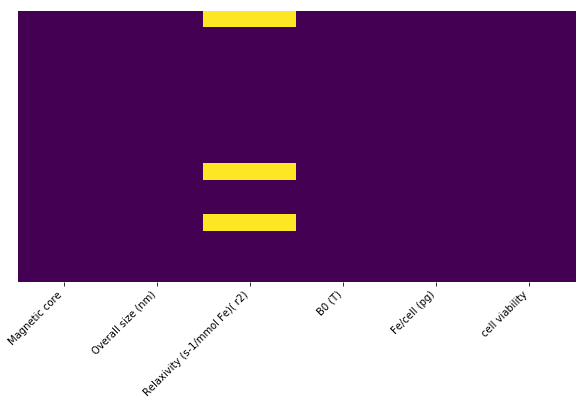

In [6]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.xticks(rotation=45,horizontalalignment='right');

From the above figure, we can see that the "Relaxivity" column has indeed 3 missing values.
In order to fill these gaps, we will apply the Hierarchical Clustering method and fill them with the mean of the relaxivity values, of the samples that are "neighbors".

In [7]:
endpoint=df.pop('cell viability')

In [8]:
df.head()

,Magnetic core,Overall size (nm),Relaxivity (s-1/mmol Fe)( r2),B0 (T),Fe/cell (pg)
0,1,15.0,NaN,1.5,64.51
1,1,10.0,549.0,4.7,29.30
2,1,2.0,509.0,4.7,21.10
3,1,10.0,492.0,4.7,24.50
4,1,10.0,89.0,4.7,23.20


In [9]:
#Scaling between 0 and 1
scaled_data = (df-df.min())/(df.max()-df.min())
scaled_data.head()

,Magnetic core,Overall size (nm),Relaxivity (s-1/mmol Fe)( r2),B0 (T),Fe/cell (pg)
0,1.0,0.087838,NaN,0.157734,0.042805
1,1.0,0.054054,1.000000,0.647779,0.018636
2,1.0,0.000000,0.923333,0.647779,0.013008
3,1.0,0.054054,0.890750,0.647779,0.015341
4,1.0,0.054054,0.118335,0.647779,0.014449


In [10]:
relax = scaled_data.pop('Relaxivity (s-1/mmol Fe)( r2)')

In [11]:
scaled_data.head()

,Magnetic core,Overall size (nm),B0 (T),Fe/cell (pg)
0,1.0,0.087838,0.157734,0.042805
1,1.0,0.054054,0.647779,0.018636
2,1.0,0.000000,0.647779,0.013008
3,1.0,0.054054,0.647779,0.015341
4,1.0,0.054054,0.647779,0.014449


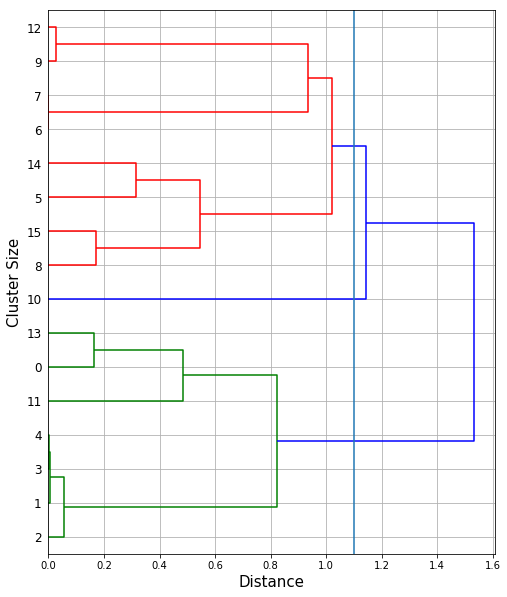

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

linked = linkage(scaled_data,method='complete')

labelList = scaled_data.index

plt.figure(figsize=(8, 10))  
dendrogram(linked,  
            orientation='right',
            labels=labelList,
            distance_sort='ascending',
            show_leaf_counts=True)

#plt.title('Agglomerative Hierarchical Clustering Dendrogram',fontsize=12)
plt.xlabel('Distance',fontsize=15)
plt.ylabel('Cluster Size',fontsize=15)

plt.axvline(x=1.1)
plt.grid(True)


plt.savefig('clusters.png')

plt.show()  

In [13]:
print('Empty Relaxivity values indices: ', list(relax[relax.isna()].index))

Empty Relaxivity values indices:  [0, 9, 12]


In [14]:
relax[0] = np.mean([relax[1],relax[2],relax[3],relax[4],relax[11],relax[13]])

In [15]:
relax[9] = np.mean([relax[5],relax[6],relax[7],relax[8],relax[14],relax[15]])
relax[12] = relax[9] 

In [16]:
relax[0]

0.5248782918695136

In [17]:
relax[9]

0.3657760570399049

In [18]:
scaled_data['relaxivity'] = relax
scaled_data['target'] = endpoint
scaled_data

,Magnetic core,Overall size (nm),B0 (T),Fe/cell (pg),relaxivity,target
0,1.0,0.087838,0.157734,0.042805,0.524878,0
1,1.0,0.054054,0.647779,0.018636,1.000000,1
2,1.0,0.000000,0.647779,0.013008,0.923333,1
3,1.0,0.054054,0.647779,0.015341,0.890750,1
4,1.0,0.054054,0.647779,0.014449,0.118335,1
5,0.0,0.356081,0.387443,0.003398,0.609001,0
6,0.0,1.000000,0.157734,0.032859,0.605359,0
7,0.0,1.000000,0.157734,0.032859,0.605359,0
8,0.0,0.360811,0.157734,0.016851,0.255376,0
9,0.0,0.621622,1.000000,0.043141,0.365776,0


### Save the dataset

In [19]:
scaled_data.to_csv('scaled_df.csv',index=False)